In [30]:
import numpy as np
from time_integrators import RK2, RK4, theta_scheme
from scipy.optimize import root
import pylab as pl
%matplotlib inline

pl.style.use('latexplot')

In [31]:
# Defining the x-domain:
x_start = 0
x_end   = 40
N_x     = 401
dx      = (x_end - x_start) / N_x

# Number of ghost cells:
N_g     = 1
x       = x_start + (0.5 + np.arange(-N_g, N_x + N_g)) * dx

In [32]:
# Defining the time array:
t_final = 40
N_t     = 40001
t       = np.linspace(0, t_final, N_t)
dt      = t[1] - t[0]

In [41]:
# Defining the dimensionless concentration of species A:
a0 = x**0

# The applied potential is going to be varied as E(t) = E_start + t
# Below, we are defining E_start (starting potential) (dicated by experimenter):
E_start = -10
# Formal potential (dictated by chemical)
E0 = -1
# Rate constant of the reaction:
k0 = 0.1
# Charge transfer coefficient:
alpha = 0.75

# Time period for cyclic voltametry:
t_rev = 20

In [42]:
def E(t):
    if((t % (2 * t_rev)) <= t_rev):
        return(E_start + t)
    else:
        return(E_start + 2 * t_rev - (t % (2 * t_rev)))

In [43]:
# Forcing function:
def F(a, t):
    return(k0 * (a * np.exp((1 - alpha) * (E(t) - E0)) - (1-a) * np.exp(-alpha * (E(t) - E0))))

In [44]:
def apply_bcs(a, t):
    # Applying the boundary conditions:
    a[0] = root(lambda x: a[1] - x - F(0.5 * (a[1] + x), t) * dx, a[1]).x
    # Boundary condition at x = infty
    a[-N_g:] = 1
    return(a)

In [45]:
def da_dt(a, t):
    # Applying the boundary conditions:
    a = apply_bcs(a, t)
    # Evaluating the 2nd derivative using central differences:
    d2a_dx2 = (np.roll(a, -1) + np.roll(a, 1) - 2 * a) / dx**2
    return d2a_dx2

In [46]:
# Evaluating the current:
I3 = np.zeros(t.size)
# Initial value of a:
a = a0
for i in range(t.size - 1):
    a = RK4(da_dt, a, t[i], t[i + 1])
    a = apply_bcs(a, t[i+1])
    I3[i] = (a[1] - a[0]) / dx

In [23]:
I_integral = np.loadtxt('I_integral2.txt')
t_integral = np.arange(0, 40, 0.01)

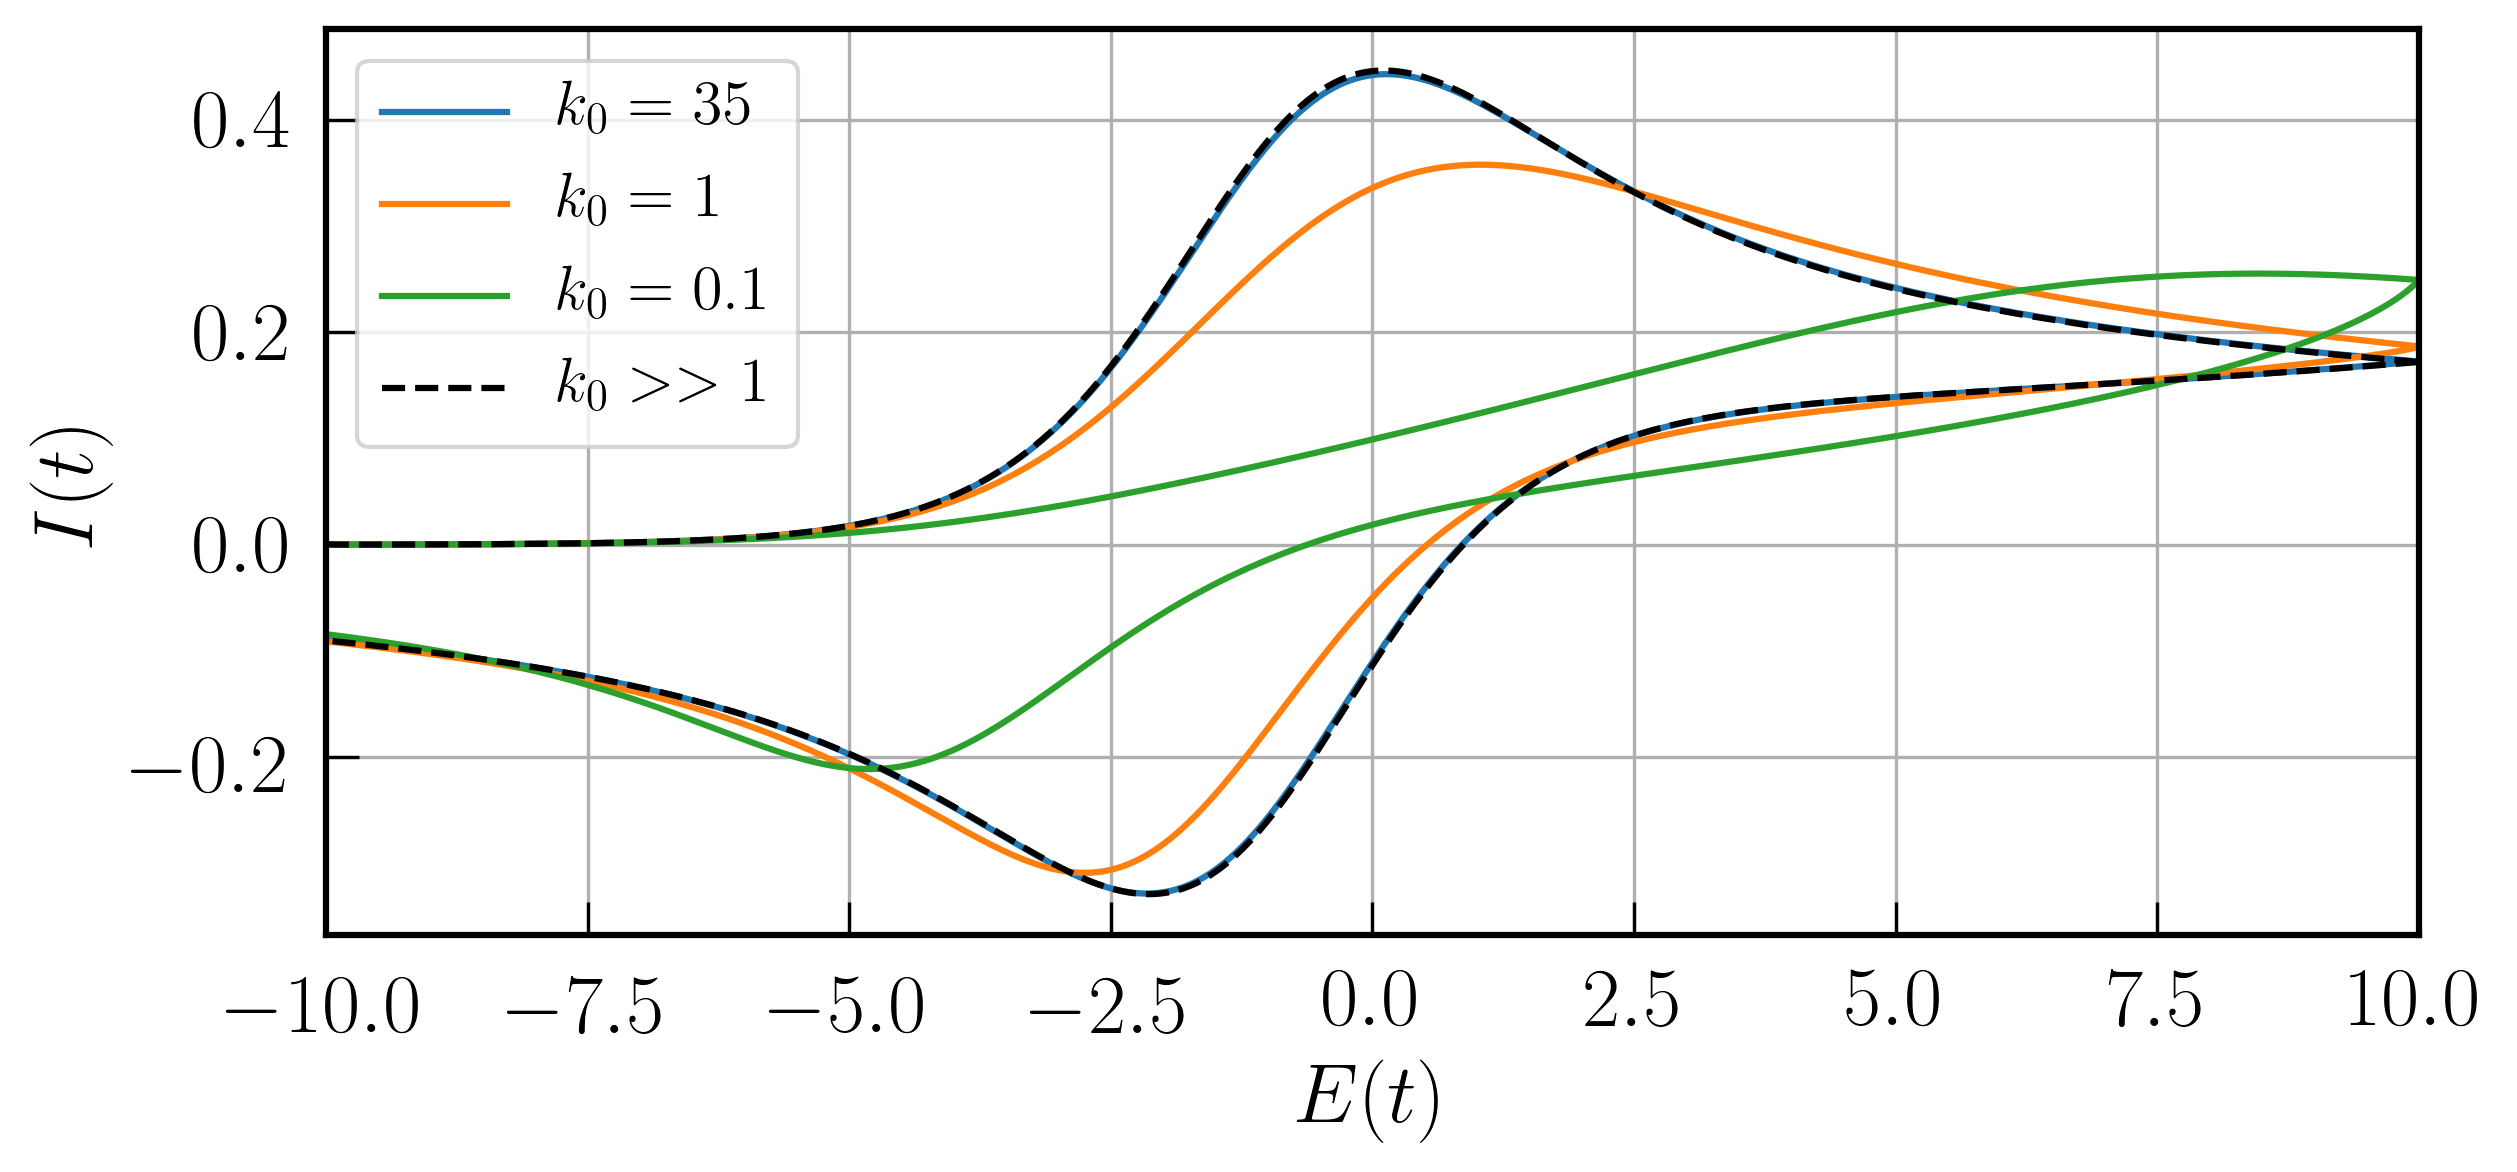

In [49]:
pl.plot(E_start + t[:int(I.size/2)], I[:int(I.size/2)], label = r'$k_0 = 35$')
pl.plot(30 - t[int(I.size/2):-10], I[int(I.size/2):-10], color = 'C0')

pl.plot(E_start + t[:int(I.size/2)], I2[:int(I.size/2)], label = r'$k_0 = 1$')
pl.plot(30 - t[int(I.size/2):-10], I2[int(I.size/2):-10], color = 'C1')

pl.plot(E_start + t[:int(I.size/2)], I3[:int(I.size/2)], label = r'$k_0 = 0.1$')
pl.plot(30 - t[int(I.size/2):-10], I3[int(I.size/2):-10], color = 'C2')

pl.ylabel(r'$I(t)$')
pl.xlabel(r'$E(t)$')
pl.xlim(-10, 10)
pl.plot(E_start + t_integral[:int(I_integral.size/2):], I_integral[:int(I_integral.size/2)], 'k--', label = r'$k_0 >> 1$')
pl.plot(30 - t_integral[int(I_integral.size/2):], I_integral[int(I_integral.size/2):], 'k--')
pl.legend(fontsize = 15)
pl.grid()
pl.savefig('current.png', bbox_inches = 'tight')

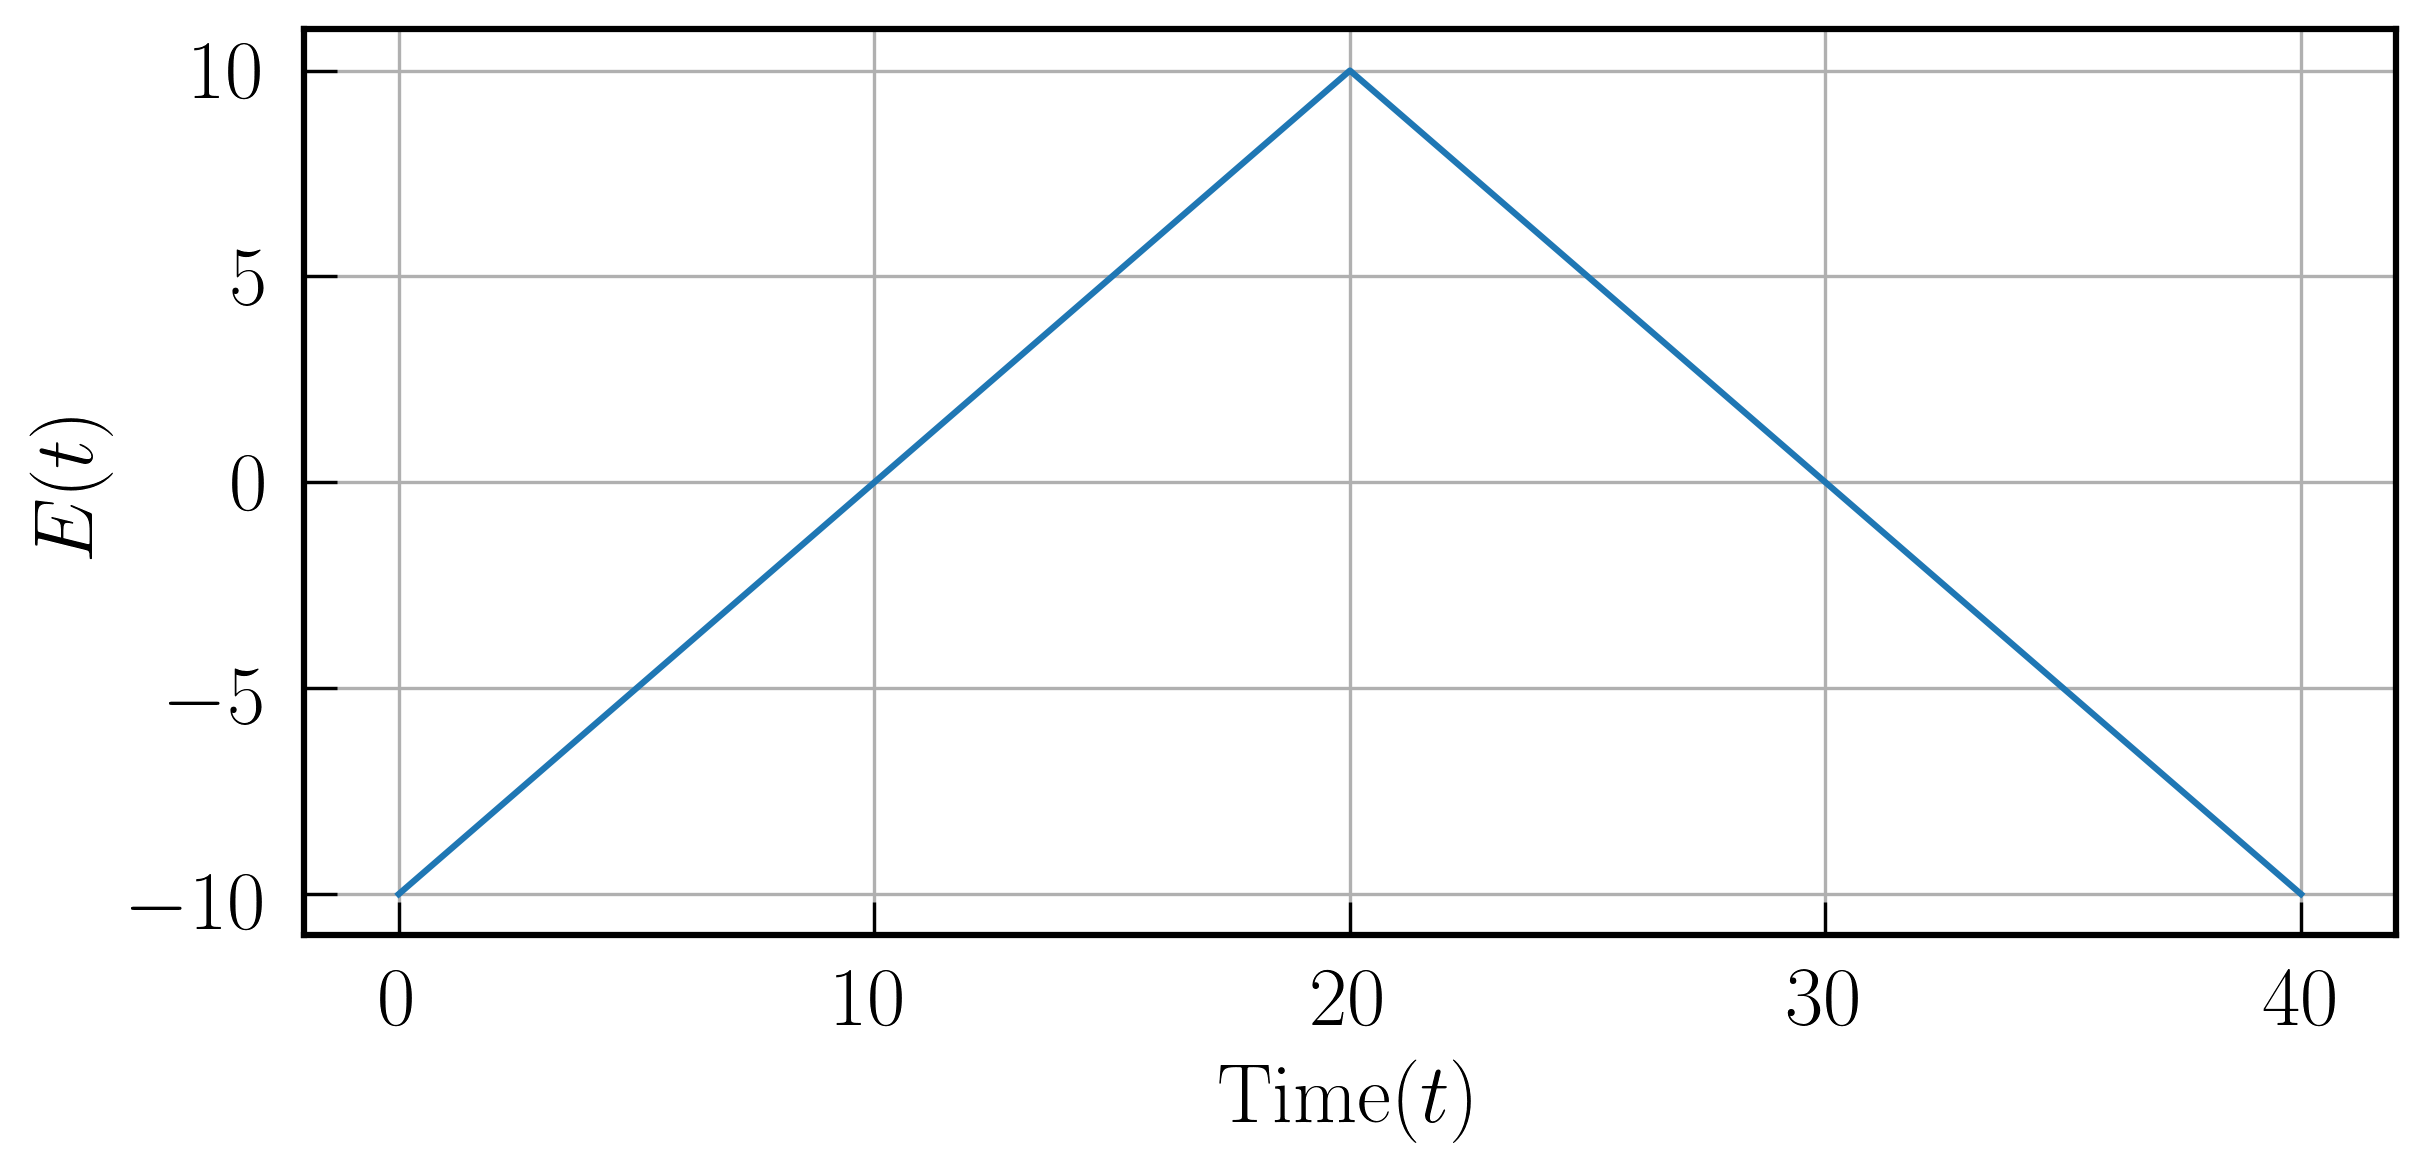

In [56]:
Emod = np.vectorize(E)
pl.plot(t[:-1], Emod(t)[:-1])
pl.ylabel(r'$E(t)$')
pl.xlabel(r'Time($t$)')
pl.grid()
pl.savefig('potential_profile_cyclic_sweep.png', bbox_inches = 'tight')